In [5]:
import math
import matplotlib.pyplot as plt
#%matplotlib inline
import numpy as np
from math import pi

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer
from qiskit.circuit import Parameter

theta1 = Parameter('θ1')
theta2 = Parameter('θ2')
variables = [theta1,theta2]

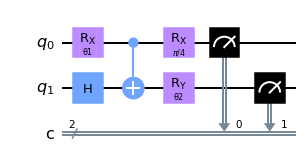

In [6]:
# create a quantum circuit with 2 parameters

qc = QuantumCircuit(2, 2)

qc.rx(theta1,0)
qc.h(1)
qc.cx(0,1)
qc.rx((pi/4),0)
qc.ry(theta2,1)

qc.measure(range(2),range(2))
qc.draw()

In [26]:
# Algorithm part

# define number for shots
shots = 1024

# transform measurement result into possibility distribution
def counts2P(counts):
    p0 = counts.get('00')
    p1 = counts.get('01')
    p2 = counts.get('10')
    p3 = counts.get('11')
    r = [0,0,0,0]
    if p0 != None:
        r[0] = p0/shots
    if p1 != None:
        r[1] = p1/shots
    if p2 != None:
        r[2] = p2/shots
    if p3 != None:
        r[3] = p3/shots
    return r

# perform the circuit and return measurement result
def runCircuitReturnCounts(qc,thetas):
    circuitToRun = qc.bind_parameters({theta1: thetas[0],theta2: thetas[1]})
    job = execute(circuitToRun, backend=BasicAer.get_backend('qasm_simulator'),shots = shots)
    result = job.result()
    return result.get_counts()

# perform the circuit and return possibility distribution
def runCircuitReturnP(qc,thetas):
    arr = counts2P(runCircuitReturnCounts(qc,thetas))
    return arr

# perform the circuit and return loss function value
def runCircuitReturnError(qc,thetas,target):
    p = runCircuitReturnP(qc,thetas)
    error = 1- p[target]
    return error

# obtain gradient
def getGradient(qc,thetas,target):
    temp1 = thetas.copy()
    temp2 = thetas.copy()
    gradients = [0,0]
    
    for i in range(2):
        temp1[i] = temp1[i]+pi/4
        temp2[i] = temp2[i]-pi/4
        gradients[i] = runCircuitReturnError(qc,temp1,target) - runCircuitReturnError(qc,temp2,target)
        temp1[i] = temp1[i]-pi/4
        temp2[i] = temp2[i]+pi/4
    
    return gradients

# a helper method
def string2Int(s):
    i = 0
    if s[0] != '0':
        i = i + 2
    if s[1] != '0':
        i = i + 1
    return i

# optimize the circuit once with a given expectedOutputState once
def learnOnce(thetas,expectedOutputState,learningRate):
    target = string2Int(expectedOutputState)
    gradient = getGradient(qc,thetas,target)
    
    thetas[0] = thetas[0] - learningRate*gradient[0]
    thetas[1] = thetas[1] - learningRate*gradient[1]
    return None

# optimize the circuit once with a given expectedOutputState 'learningTimes'-times and store the parameter and the performance of the circuit after each step
registerForTheta = np.zeros((20,2))
registerForP = np.zeros(20)
def letsLearn(initalValue,learningRate,expectedOutputState,learningTimes,showError):
    for i in range(learningTimes):
        registerForTheta[i] = initalValue.copy()
        if showError:
            print('this is step ' + str(i))
            print('Error:',end = ' ')
            print(runCircuitReturnError(qc,initalValue,string2Int(target)))
        registerForP[i] = 1- runCircuitReturnError(qc,initalValue,string2Int(expectedOutputState))
        learnOnce(initalValue,expectedOutputState,LR)
    return None


In [29]:
# define the simulation you want and change the last parameter of function 'letsLearn' to show Error after each optimization step
expectedOutputS = '11'
thetas = [1.4*pi,1.4*pi]
LR = 0.25*pi
letsLearn(thetas,LR,expectedOutputS,20,False)

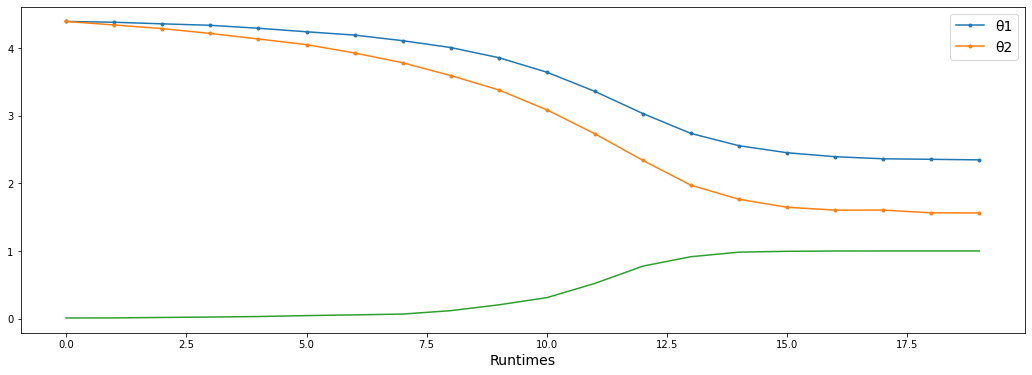

In [33]:
# generate figure
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111)

x1 = np.zeros(20)
x2 = np.zeros(20)
for i in range(20):
    x1[i] = registerForTheta[i][0]
    x2[i] = registerForTheta[i][1]
    
ax.plot(range(20), x1,'.-', label='θ1')
ax.plot(range(20), x2,'.-', label='θ2')
ax.plot(range(20), registerForP)
ax.set_xlabel('Runtimes', fontsize=14)
ax.legend(fontsize=14)